# Does cluster-packing save energy?
This notebook runs a workload at various frequencies. The workload is run both force-packed onto a single cluster and force-spread across two clusters, and the energy is compared.

The target configuration (with AEP configuration) should be in target.conf.

This assumes an SMP-like system e.g. HiKey, Pixel, with two clusters.

## Setup...

In [1]:
# Various setup, probably mostly unused

from env import TestEnv
import pandas as pd
import json
import os
from conf import LisaLogging
from bart.common.Utils import area_under_curve
from trappy.plotter import plot_trace
from IPython.display import display
from trappy import ILinePlot
from trappy.stats.grammar import Parser
from bart.sched.SchedMultiAssert import SchedMultiAssert
import pandas as pd
from trace import Trace
LisaLogging.setup()
import logging
logging.getLogger('Trace').setLevel(logging.ERROR)
logging.getLogger('Analysis').setLevel(logging.WARNING)
logging.getLogger('EnergyMeter').setLevel(logging.DEBUG)
%matplotlib inline
from platforms.juno_energy import juno_energy
from platforms.pixel_energy import pixel_energy
import tests.eas.generic
import numpy as np
from IPython.display import display
from wlgen import RTA, Periodic
from executor import Executor
from platforms.hikey_energy import hikey_energy
import numpy as np

2017-03-15 18:41:50,215 INFO    : root         : Using LISA logging configuration:
2017-03-15 18:41:50,216 INFO    : root         :   /home/brejac01/sources/lisa/logging.conf


In [2]:
# Some nonsense to get caiman to work on Brendan's computer
p = os.getenv('PATH').split(':')
caiman_path = '/opt/ds5_v5.23.0/bin'
if caiman_path not in p:
    p.insert(0, caiman_path)
    os.environ['PATH'] = ':'.join(p)

In [3]:
te = TestEnv(test_conf={
        'modules': ['cgroups'], 
        'ftrace': {
            'events': ['sched_switch', 'cpu_frequency', 'cpu_idle', 'sched_load_avg_cpu', 'sched_load_avg_task', 'irq*']
        }
    }, force_new=True)

2017-03-15 18:41:50,266 INFO    : TestEnv      : Using base path: /home/brejac01/sources/lisa
2017-03-15 18:41:50,267 INFO    : TestEnv      : Loading default (file) target configuration
2017-03-15 18:41:50,267 INFO    : TestEnv      : Loading target configuration [/home/brejac01/sources/lisa/target.config]...
2017-03-15 18:41:50,269 INFO    : TestEnv      : Loading custom (inline) test configuration
2017-03-15 18:41:50,270 INFO    : TestEnv      : External tools using:
2017-03-15 18:41:50,270 INFO    : TestEnv      :    ANDROID_HOME: /work/android-sdk-linux
2017-03-15 18:41:50,271 INFO    : TestEnv      :    CATAPULT_HOME: /home/brejac01/sources/lisa/tools/catapult
2017-03-15 18:41:50,271 INFO    : TestEnv      : Devlib modules to load: ['cpuidle', 'cpufreq', 'cgroups']
2017-03-15 18:41:50,272 INFO    : TestEnv      : Connecting Android target [04D314DF000BC57F]
2017-03-15 18:41:50,273 INFO    : TestEnv      : Connection settings:
2017-03-15 18:41:50,273 INFO    : TestEnv      :    {'

In [4]:
# Some nonsense to make LISA treat HiKey with the respect it deserves
if te.conf['board'] == 'hikey':
    from trappy.stats.Topology import Topology
    hikey_topology = Topology(clusters=[[0, 1, 2, 3], [4, 5, 6, 7]])
    te.topology = hikey_topology
    te.platform['clusters'] = {'big': [0, 1, 2, 3], 'little': [4, 5, 6, 7]}

# Define Workloads
We're going to create two workloads with a handful of small tasks, such that they could fit onto a single cluster at the lowest OPP. 

To avoid evertying being thrown out by the periodiciy of the tasks, the start times and periods of the tasks are staggered.

We'll run this same workload both with and without using taskset to force them onto a single cluster.

In [5]:
def get_wloads(nrg_model, cpu=0, type='min', bandwidth_to_eat=0.25, ntasks=16):
    cpu_node = nrg_model.cpu_nodes[cpu]
    cluster_node = cpu_node.parent
    ncpus = len(cluster_node.cpus)
    if type == 'min':
        cpu_cap = cpu_node.min_capacity
    elif type == 'max':
        cpu_cap = cpu_node.max_capacity
        
    total_cap = bandwidth_to_eat * ncpus * cpu_cap
    target_task_cap = total_cap / ntasks
    task_pct = int((target_task_cap / 1024) * 100)
    task_cap = int(1024 * (task_pct / 100.))
    tasks_per_cpu = int(cpu_cap / task_cap)
    
    print 'Will create workloads with {} tasks each using {} capacity'.format(ntasks, task_cap)
    
    # Stagger the workloads so that they prevent shared idle states
    period_s = 10e-3
    stagger_s = 0.7e-3
    delays = np.arange(period_s, step=stagger_s)
    
    if len(delays) > ntasks:
        print "WARNING: not enough tasks to cover period with wakeups"
    
    # Figure out a set of CPUs that spans both clusters
    [cluster0, cluster1] = te.platform['clusters'].values()
    cpu_pairs = zip(cluster0, cluster1)
    print cluster0, cluster1, cpu_pairs
    cluster_spread_cpuset = reduce(lambda x, y: x + y, cpu_pairs[0:len(cpu_pairs) / 2])
    
    tasks = {}
    for i in range(ntasks):
        tasks['{}pct_{}'.format(task_pct, i)] = {
            'kind': 'Periodic',
            'params': {
                'duty_cycle_pct': task_pct,
                'period_ms' : period_s * 1e3 + (i - (ntasks / 2)),
                'delay_s' : delays[i % len(delays)],
                'duration_s': 3
            }
        }
    
    wloads = {
        'forced_pack': {
            'type': 'rt-app',
            'conf': {
                'class': 'profile',
                'params': tasks,
                'cpus': cluster0,
                'duration': 3,
            }
        },
        'break_packing': {
            'type': 'rt-app',
            'conf': {
                'class': 'profile',
                'params': tasks,
                'cpus': cluster_spread_cpuset,
                'duration': 3,
            }
        }
    }
        
    return wloads

In [6]:
wloads = get_wloads(te.nrg_model, type='max')

Will create workloads with 16 tasks each using 61 capacity
[0, 1, 2, 3] [4, 5, 6, 7] [(0, 4), (1, 5), (2, 6), (3, 7)]


# Run workloads
Now we'll run the workloads with the powersave governor

In [7]:
# Find frequencies that all CPUs can run at
shared_freqs = sorted(set.intersection(*[set(te.target.cpufreq.list_frequencies(c)) 
                                         for c in range(te.target.number_of_cpus)]))

In [8]:
executor = Executor(te, {
        'confs': [{
            'tag': 'freq_{}'.format(freq),
            'flags': ['ftrace', 'freeze_userspace'],
            'cpufreq': {
                'governor': 'userspace',
                'freqs': {cpu: freq for cpu in range(te.target.number_of_cpus)}
            },
        } for freq in shared_freqs[::len(shared_freqs)/5]],
        'wloads': wloads,
        'iterations': 5
    })

2017-03-15 18:42:00,465 INFO    : Executor     : Loading custom (inline) test configuration
2017-03-15 18:42:00,467 INFO    : Executor     : 
2017-03-15 18:42:00,468 INFO    : Executor     : ################################################################################
2017-03-15 18:42:00,469 INFO    : Executor     : Experiments configuration
2017-03-15 18:42:00,470 INFO    : Executor     : ################################################################################
2017-03-15 18:42:00,472 INFO    : Executor     : Configured to run:
2017-03-15 18:42:00,473 INFO    : Executor     :      5 target configurations:
2017-03-15 18:42:00,474 INFO    : Executor     :       freq_208000, freq_432000, freq_729000, freq_960000, freq_1200000
2017-03-15 18:42:00,475 INFO    : Executor     :      2 workloads (5 iterations each)
2017-03-15 18:42:00,476 INFO    : Executor     :       break_packing, forced_pack
2017-03-15 18:42:00,477 INFO    : Executor     : Total: 50 experiments
2017-03-15 18:42:

In [9]:
executor.run()

2017-03-15 18:42:02,824 INFO    : Executor     : 
2017-03-15 18:42:02,827 INFO    : Executor     : ################################################################################
2017-03-15 18:42:02,828 INFO    : Executor     : Experiments execution
2017-03-15 18:42:02,829 INFO    : Executor     : ################################################################################
2017-03-15 18:42:02,830 INFO    : Executor     : 
2017-03-15 18:42:02,831 INFO    : Executor     : ================================================================================
2017-03-15 18:42:02,832 INFO    : Executor     : configuring target for [freq_208000] experiments
2017-03-15 18:42:03,143 WARNING : Executor     : Setting target SELinux in permissive mode
2017-03-15 18:42:03,310 INFO    : Executor     : Configuring all CPUs to use [userspace] cpufreq governor
2017-03-15 18:42:03,474 INFO    : Executor     :        CPUFreq - CPU frequencies: {0: 208000, 1: 208000, 2: 208000, 3: 208000, 4: 208000, 5: 20

2017-03-15 18:43:07,074 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.145093
2017-03-15 18:43:28,804 INFO    : Executor     : Collected FTrace binary trace:
2017-03-15 18:43:28,806 INFO    : Executor     :    <res_dir>/rtapp:freq_208000:break_packing/1/trace.dat
2017-03-15 18:43:28,808 INFO    : Executor     : Collected FTrace function profiling:
2017-03-15 18:43:28,809 INFO    : Executor     :    <res_dir>/rtapp:freq_208000:break_packing/1/trace_stat.json
2017-03-15 18:43:28,810 INFO    : Executor     : Un-freezing userspace tasks
2017-03-15 18:43:33,171 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-15 18:43:33,174 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-15 18:43:33,175 INFO    : Executor     : Experiment 1/50, [freq_208000:break_packing] 2/5
2017-03-15 18:43:33,473 INFO    : Executor     : Freezing all tasks except: sh,adbd,init,usb,tra

2017-03-15 18:44:21,361 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.143491
2017-03-15 18:44:43,053 INFO    : Executor     : Collected FTrace binary trace:
2017-03-15 18:44:43,055 INFO    : Executor     :    <res_dir>/rtapp:freq_208000:break_packing/2/trace.dat
2017-03-15 18:44:43,056 INFO    : Executor     : Collected FTrace function profiling:
2017-03-15 18:44:43,057 INFO    : Executor     :    <res_dir>/rtapp:freq_208000:break_packing/2/trace_stat.json
2017-03-15 18:44:43,059 INFO    : Executor     : Un-freezing userspace tasks
2017-03-15 18:44:46,576 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-15 18:44:46,578 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-15 18:44:46,579 INFO    : Executor     : Experiment 2/50, [freq_208000:break_packing] 3/5
2017-03-15 18:44:46,868 INFO    : Executor     : Freezing all tasks except: sh,adbd,init,usb,tra

2017-03-15 18:45:34,758 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.145246
2017-03-15 18:45:56,947 INFO    : Executor     : Collected FTrace binary trace:
2017-03-15 18:45:56,949 INFO    : Executor     :    <res_dir>/rtapp:freq_208000:break_packing/3/trace.dat
2017-03-15 18:45:56,951 INFO    : Executor     : Collected FTrace function profiling:
2017-03-15 18:45:56,952 INFO    : Executor     :    <res_dir>/rtapp:freq_208000:break_packing/3/trace_stat.json
2017-03-15 18:45:56,953 INFO    : Executor     : Un-freezing userspace tasks
2017-03-15 18:46:00,615 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-15 18:46:00,618 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-15 18:46:00,619 INFO    : Executor     : Experiment 3/50, [freq_208000:break_packing] 4/5
2017-03-15 18:46:00,891 INFO    : Executor     : Freezing all tasks except: sh,adbd,init,usb,tra

2017-03-15 18:46:48,674 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.141924
2017-03-15 18:47:10,258 INFO    : Executor     : Collected FTrace binary trace:
2017-03-15 18:47:10,260 INFO    : Executor     :    <res_dir>/rtapp:freq_208000:break_packing/4/trace.dat
2017-03-15 18:47:10,261 INFO    : Executor     : Collected FTrace function profiling:
2017-03-15 18:47:10,262 INFO    : Executor     :    <res_dir>/rtapp:freq_208000:break_packing/4/trace_stat.json
2017-03-15 18:47:10,263 INFO    : Executor     : Un-freezing userspace tasks
2017-03-15 18:47:13,813 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-15 18:47:13,816 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-15 18:47:13,817 INFO    : Executor     : Experiment 4/50, [freq_208000:break_packing] 5/5
2017-03-15 18:47:14,089 INFO    : Executor     : Freezing all tasks except: sh,adbd,init,usb,tra

2017-03-15 18:48:02,282 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.142761
2017-03-15 18:48:23,952 INFO    : Executor     : Collected FTrace binary trace:
2017-03-15 18:48:23,954 INFO    : Executor     :    <res_dir>/rtapp:freq_208000:break_packing/5/trace.dat
2017-03-15 18:48:23,955 INFO    : Executor     : Collected FTrace function profiling:
2017-03-15 18:48:23,957 INFO    : Executor     :    <res_dir>/rtapp:freq_208000:break_packing/5/trace_stat.json
2017-03-15 18:48:23,958 INFO    : Executor     : Un-freezing userspace tasks
2017-03-15 18:48:27,591 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-15 18:48:27,594 INFO    : Workload     : Setup new workload forced_pack
2017-03-15 18:48:28,040 WARNING : Workload     : Limiting workload duration to 3 [s]
2017-03-15 18:48:28,041 INFO    : Workload     : Default policy: SCHED_OTHER
2017-03-15 18:48:28,043 INFO    : Workload     : ------------------------
2017-03-

2017-03-15 18:49:16,803 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.144643
2017-03-15 18:49:38,972 INFO    : Executor     : Collected FTrace binary trace:
2017-03-15 18:49:38,974 INFO    : Executor     :    <res_dir>/rtapp:freq_208000:forced_pack/1/trace.dat
2017-03-15 18:49:38,975 INFO    : Executor     : Collected FTrace function profiling:
2017-03-15 18:49:38,976 INFO    : Executor     :    <res_dir>/rtapp:freq_208000:forced_pack/1/trace_stat.json
2017-03-15 18:49:38,977 INFO    : Executor     : Un-freezing userspace tasks
2017-03-15 18:49:42,620 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-15 18:49:42,622 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-15 18:49:42,623 INFO    : Executor     : Experiment 6/50, [freq_208000:forced_pack] 2/5
2017-03-15 18:49:42,887 INFO    : Executor     : Freezing all tasks except: sh,adbd,init,usb,transport

2017-03-15 18:50:31,098 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.144741
2017-03-15 18:50:52,940 INFO    : Executor     : Collected FTrace binary trace:
2017-03-15 18:50:52,942 INFO    : Executor     :    <res_dir>/rtapp:freq_208000:forced_pack/2/trace.dat
2017-03-15 18:50:52,943 INFO    : Executor     : Collected FTrace function profiling:
2017-03-15 18:50:52,944 INFO    : Executor     :    <res_dir>/rtapp:freq_208000:forced_pack/2/trace_stat.json
2017-03-15 18:50:52,946 INFO    : Executor     : Un-freezing userspace tasks
2017-03-15 18:50:56,460 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-15 18:50:56,463 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-15 18:50:56,464 INFO    : Executor     : Experiment 7/50, [freq_208000:forced_pack] 3/5
2017-03-15 18:50:56,744 INFO    : Executor     : Freezing all tasks except: sh,adbd,init,usb,transport

2017-03-15 18:51:44,638 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.143169
2017-03-15 18:52:06,624 INFO    : Executor     : Collected FTrace binary trace:
2017-03-15 18:52:06,626 INFO    : Executor     :    <res_dir>/rtapp:freq_208000:forced_pack/3/trace.dat
2017-03-15 18:52:06,627 INFO    : Executor     : Collected FTrace function profiling:
2017-03-15 18:52:06,628 INFO    : Executor     :    <res_dir>/rtapp:freq_208000:forced_pack/3/trace_stat.json
2017-03-15 18:52:06,629 INFO    : Executor     : Un-freezing userspace tasks
2017-03-15 18:52:10,182 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-15 18:52:10,184 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-15 18:52:10,185 INFO    : Executor     : Experiment 8/50, [freq_208000:forced_pack] 4/5
2017-03-15 18:52:10,445 INFO    : Executor     : Freezing all tasks except: sh,adbd,init,usb,transport

2017-03-15 18:52:58,036 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.143744
2017-03-15 18:53:19,943 INFO    : Executor     : Collected FTrace binary trace:
2017-03-15 18:53:19,946 INFO    : Executor     :    <res_dir>/rtapp:freq_208000:forced_pack/4/trace.dat
2017-03-15 18:53:19,947 INFO    : Executor     : Collected FTrace function profiling:
2017-03-15 18:53:19,948 INFO    : Executor     :    <res_dir>/rtapp:freq_208000:forced_pack/4/trace_stat.json
2017-03-15 18:53:19,949 INFO    : Executor     : Un-freezing userspace tasks
2017-03-15 18:53:23,477 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-15 18:53:23,479 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-15 18:53:23,480 INFO    : Executor     : Experiment 9/50, [freq_208000:forced_pack] 5/5
2017-03-15 18:53:23,746 INFO    : Executor     : Freezing all tasks except: sh,adbd,init,usb,transport

2017-03-15 18:54:11,422 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.145519
2017-03-15 18:54:33,431 INFO    : Executor     : Collected FTrace binary trace:
2017-03-15 18:54:33,433 INFO    : Executor     :    <res_dir>/rtapp:freq_208000:forced_pack/5/trace.dat
2017-03-15 18:54:33,434 INFO    : Executor     : Collected FTrace function profiling:
2017-03-15 18:54:33,435 INFO    : Executor     :    <res_dir>/rtapp:freq_208000:forced_pack/5/trace_stat.json
2017-03-15 18:54:33,437 INFO    : Executor     : Un-freezing userspace tasks
2017-03-15 18:54:36,989 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-15 18:54:36,991 INFO    : Executor     : Restoring target SELinux mode: Permissive

2017-03-15 18:54:37,787 INFO    : Executor     : 
2017-03-15 18:54:37,789 INFO    : Executor     : ================================================================================
2017-03-15 18:54:37,790 INFO    : Executor     : configu

2017-03-15 18:55:16,789 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.093256
2017-03-15 18:55:28,098 INFO    : Executor     : Collected FTrace binary trace:
2017-03-15 18:55:28,100 INFO    : Executor     :    <res_dir>/rtapp:freq_432000:break_packing/1/trace.dat
2017-03-15 18:55:28,102 INFO    : Executor     : Collected FTrace function profiling:
2017-03-15 18:55:28,103 INFO    : Executor     :    <res_dir>/rtapp:freq_432000:break_packing/1/trace_stat.json
2017-03-15 18:55:28,104 INFO    : Executor     : Un-freezing userspace tasks
2017-03-15 18:55:29,951 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-15 18:55:29,953 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-15 18:55:29,954 INFO    : Executor     : Experiment 11/50, [freq_432000:break_packing] 2/5
2017-03-15 18:55:30,095 INFO    : Executor     : Freezing all tasks except: sh,adbd,init,usb,tr

2017-03-15 18:55:57,149 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.092206
2017-03-15 18:56:08,189 INFO    : Executor     : Collected FTrace binary trace:
2017-03-15 18:56:08,191 INFO    : Executor     :    <res_dir>/rtapp:freq_432000:break_packing/2/trace.dat
2017-03-15 18:56:08,192 INFO    : Executor     : Collected FTrace function profiling:
2017-03-15 18:56:08,193 INFO    : Executor     :    <res_dir>/rtapp:freq_432000:break_packing/2/trace_stat.json
2017-03-15 18:56:08,195 INFO    : Executor     : Un-freezing userspace tasks
2017-03-15 18:56:10,175 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-15 18:56:10,177 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-15 18:56:10,178 INFO    : Executor     : Experiment 12/50, [freq_432000:break_packing] 3/5
2017-03-15 18:56:10,320 INFO    : Executor     : Freezing all tasks except: sh,adbd,init,usb,tr

2017-03-15 18:56:37,334 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.091794
2017-03-15 18:56:48,296 INFO    : Executor     : Collected FTrace binary trace:
2017-03-15 18:56:48,298 INFO    : Executor     :    <res_dir>/rtapp:freq_432000:break_packing/3/trace.dat
2017-03-15 18:56:48,300 INFO    : Executor     : Collected FTrace function profiling:
2017-03-15 18:56:48,301 INFO    : Executor     :    <res_dir>/rtapp:freq_432000:break_packing/3/trace_stat.json
2017-03-15 18:56:48,302 INFO    : Executor     : Un-freezing userspace tasks
2017-03-15 18:56:50,060 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-15 18:56:50,062 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-15 18:56:50,063 INFO    : Executor     : Experiment 13/50, [freq_432000:break_packing] 4/5
2017-03-15 18:56:50,212 INFO    : Executor     : Freezing all tasks except: sh,adbd,init,usb,tr

2017-03-15 18:57:17,509 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.092360
2017-03-15 18:57:28,319 INFO    : Executor     : Collected FTrace binary trace:
2017-03-15 18:57:28,321 INFO    : Executor     :    <res_dir>/rtapp:freq_432000:break_packing/4/trace.dat
2017-03-15 18:57:28,323 INFO    : Executor     : Collected FTrace function profiling:
2017-03-15 18:57:28,324 INFO    : Executor     :    <res_dir>/rtapp:freq_432000:break_packing/4/trace_stat.json
2017-03-15 18:57:28,325 INFO    : Executor     : Un-freezing userspace tasks
2017-03-15 18:57:30,132 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-15 18:57:30,134 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-15 18:57:30,135 INFO    : Executor     : Experiment 14/50, [freq_432000:break_packing] 5/5
2017-03-15 18:57:30,276 INFO    : Executor     : Freezing all tasks except: sh,adbd,init,usb,tr

2017-03-15 18:57:57,602 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.092764
2017-03-15 18:58:08,212 INFO    : Executor     : Collected FTrace binary trace:
2017-03-15 18:58:08,215 INFO    : Executor     :    <res_dir>/rtapp:freq_432000:break_packing/5/trace.dat
2017-03-15 18:58:08,216 INFO    : Executor     : Collected FTrace function profiling:
2017-03-15 18:58:08,217 INFO    : Executor     :    <res_dir>/rtapp:freq_432000:break_packing/5/trace_stat.json
2017-03-15 18:58:08,218 INFO    : Executor     : Un-freezing userspace tasks
2017-03-15 18:58:09,988 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-15 18:58:09,991 INFO    : Workload     : Setup new workload forced_pack
2017-03-15 18:58:10,214 WARNING : Workload     : Limiting workload duration to 3 [s]
2017-03-15 18:58:10,216 INFO    : Workload     : Default policy: SCHED_OTHER
2017-03-15 18:58:10,217 INFO    : Workload     : ------------------------
2017-03-

2017-03-15 18:58:37,824 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.093766
2017-03-15 18:58:49,408 INFO    : Executor     : Collected FTrace binary trace:
2017-03-15 18:58:49,410 INFO    : Executor     :    <res_dir>/rtapp:freq_432000:forced_pack/1/trace.dat
2017-03-15 18:58:49,412 INFO    : Executor     : Collected FTrace function profiling:
2017-03-15 18:58:49,413 INFO    : Executor     :    <res_dir>/rtapp:freq_432000:forced_pack/1/trace_stat.json
2017-03-15 18:58:49,415 INFO    : Executor     : Un-freezing userspace tasks
2017-03-15 18:58:51,212 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-15 18:58:51,214 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-15 18:58:51,215 INFO    : Executor     : Experiment 16/50, [freq_432000:forced_pack] 2/5
2017-03-15 18:58:51,376 INFO    : Executor     : Freezing all tasks except: sh,adbd,init,usb,transpor

2017-03-15 18:59:18,586 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.094049
2017-03-15 18:59:29,672 INFO    : Executor     : Collected FTrace binary trace:
2017-03-15 18:59:29,674 INFO    : Executor     :    <res_dir>/rtapp:freq_432000:forced_pack/2/trace.dat
2017-03-15 18:59:29,675 INFO    : Executor     : Collected FTrace function profiling:
2017-03-15 18:59:29,677 INFO    : Executor     :    <res_dir>/rtapp:freq_432000:forced_pack/2/trace_stat.json
2017-03-15 18:59:29,678 INFO    : Executor     : Un-freezing userspace tasks
2017-03-15 18:59:31,564 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-15 18:59:31,566 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-15 18:59:31,567 INFO    : Executor     : Experiment 17/50, [freq_432000:forced_pack] 3/5
2017-03-15 18:59:31,714 INFO    : Executor     : Freezing all tasks except: sh,adbd,init,usb,transpor

2017-03-15 18:59:58,935 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.094347
2017-03-15 19:00:09,958 INFO    : Executor     : Collected FTrace binary trace:
2017-03-15 19:00:09,960 INFO    : Executor     :    <res_dir>/rtapp:freq_432000:forced_pack/3/trace.dat
2017-03-15 19:00:09,962 INFO    : Executor     : Collected FTrace function profiling:
2017-03-15 19:00:09,963 INFO    : Executor     :    <res_dir>/rtapp:freq_432000:forced_pack/3/trace_stat.json
2017-03-15 19:00:09,964 INFO    : Executor     : Un-freezing userspace tasks
2017-03-15 19:00:11,742 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-15 19:00:11,744 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-15 19:00:11,746 INFO    : Executor     : Experiment 18/50, [freq_432000:forced_pack] 4/5
2017-03-15 19:00:11,893 INFO    : Executor     : Freezing all tasks except: sh,adbd,init,usb,transpor

2017-03-15 19:00:39,245 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.093755
2017-03-15 19:00:50,283 INFO    : Executor     : Collected FTrace binary trace:
2017-03-15 19:00:50,285 INFO    : Executor     :    <res_dir>/rtapp:freq_432000:forced_pack/4/trace.dat
2017-03-15 19:00:50,287 INFO    : Executor     : Collected FTrace function profiling:
2017-03-15 19:00:50,288 INFO    : Executor     :    <res_dir>/rtapp:freq_432000:forced_pack/4/trace_stat.json
2017-03-15 19:00:50,289 INFO    : Executor     : Un-freezing userspace tasks
2017-03-15 19:00:52,275 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-15 19:00:52,277 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-15 19:00:52,279 INFO    : Executor     : Experiment 19/50, [freq_432000:forced_pack] 5/5
2017-03-15 19:00:52,440 INFO    : Executor     : Freezing all tasks except: sh,adbd,init,usb,transpor

2017-03-15 19:01:19,691 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.093747
2017-03-15 19:01:31,181 INFO    : Executor     : Collected FTrace binary trace:
2017-03-15 19:01:31,183 INFO    : Executor     :    <res_dir>/rtapp:freq_432000:forced_pack/5/trace.dat
2017-03-15 19:01:31,185 INFO    : Executor     : Collected FTrace function profiling:
2017-03-15 19:01:31,186 INFO    : Executor     :    <res_dir>/rtapp:freq_432000:forced_pack/5/trace_stat.json
2017-03-15 19:01:31,187 INFO    : Executor     : Un-freezing userspace tasks
2017-03-15 19:01:33,034 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-15 19:01:33,037 INFO    : Executor     : Restoring target SELinux mode: Permissive

2017-03-15 19:01:33,435 INFO    : Executor     : 
2017-03-15 19:01:33,436 INFO    : Executor     : ================================================================================
2017-03-15 19:01:33,438 INFO    : Executor     : configu

2017-03-15 19:02:00,186 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.074688
2017-03-15 19:02:08,260 INFO    : Executor     : Collected FTrace binary trace:
2017-03-15 19:02:08,262 INFO    : Executor     :    <res_dir>/rtapp:freq_729000:break_packing/1/trace.dat
2017-03-15 19:02:08,263 INFO    : Executor     : Collected FTrace function profiling:
2017-03-15 19:02:08,264 INFO    : Executor     :    <res_dir>/rtapp:freq_729000:break_packing/1/trace_stat.json
2017-03-15 19:02:08,266 INFO    : Executor     : Un-freezing userspace tasks
2017-03-15 19:02:09,347 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-15 19:02:09,349 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-15 19:02:09,350 INFO    : Executor     : Experiment 21/50, [freq_729000:break_packing] 2/5
2017-03-15 19:02:09,457 INFO    : Executor     : Freezing all tasks except: sh,adbd,init,usb,tr

2017-03-15 19:02:29,072 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.074982
2017-03-15 19:02:36,993 INFO    : Executor     : Collected FTrace binary trace:
2017-03-15 19:02:36,995 INFO    : Executor     :    <res_dir>/rtapp:freq_729000:break_packing/2/trace.dat
2017-03-15 19:02:36,996 INFO    : Executor     : Collected FTrace function profiling:
2017-03-15 19:02:36,997 INFO    : Executor     :    <res_dir>/rtapp:freq_729000:break_packing/2/trace_stat.json
2017-03-15 19:02:36,998 INFO    : Executor     : Un-freezing userspace tasks
2017-03-15 19:02:38,078 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-15 19:02:38,080 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-15 19:02:38,081 INFO    : Executor     : Experiment 22/50, [freq_729000:break_packing] 3/5
2017-03-15 19:02:38,181 INFO    : Executor     : Freezing all tasks except: sh,adbd,init,usb,tr

2017-03-15 19:02:57,974 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.074585
2017-03-15 19:03:05,878 INFO    : Executor     : Collected FTrace binary trace:
2017-03-15 19:03:05,880 INFO    : Executor     :    <res_dir>/rtapp:freq_729000:break_packing/3/trace.dat
2017-03-15 19:03:05,881 INFO    : Executor     : Collected FTrace function profiling:
2017-03-15 19:03:05,882 INFO    : Executor     :    <res_dir>/rtapp:freq_729000:break_packing/3/trace_stat.json
2017-03-15 19:03:05,883 INFO    : Executor     : Un-freezing userspace tasks
2017-03-15 19:03:06,972 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-15 19:03:06,974 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-15 19:03:06,976 INFO    : Executor     : Experiment 23/50, [freq_729000:break_packing] 4/5
2017-03-15 19:03:07,076 INFO    : Executor     : Freezing all tasks except: sh,adbd,init,usb,tr

2017-03-15 19:03:26,690 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.074495
2017-03-15 19:03:34,528 INFO    : Executor     : Collected FTrace binary trace:
2017-03-15 19:03:34,530 INFO    : Executor     :    <res_dir>/rtapp:freq_729000:break_packing/4/trace.dat
2017-03-15 19:03:34,531 INFO    : Executor     : Collected FTrace function profiling:
2017-03-15 19:03:34,532 INFO    : Executor     :    <res_dir>/rtapp:freq_729000:break_packing/4/trace_stat.json
2017-03-15 19:03:34,533 INFO    : Executor     : Un-freezing userspace tasks
2017-03-15 19:03:35,675 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-15 19:03:35,677 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-15 19:03:35,678 INFO    : Executor     : Experiment 24/50, [freq_729000:break_packing] 5/5
2017-03-15 19:03:35,779 INFO    : Executor     : Freezing all tasks except: sh,adbd,init,usb,tr

2017-03-15 19:03:55,323 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.074905
2017-03-15 19:04:03,083 INFO    : Executor     : Collected FTrace binary trace:
2017-03-15 19:04:03,085 INFO    : Executor     :    <res_dir>/rtapp:freq_729000:break_packing/5/trace.dat
2017-03-15 19:04:03,086 INFO    : Executor     : Collected FTrace function profiling:
2017-03-15 19:04:03,087 INFO    : Executor     :    <res_dir>/rtapp:freq_729000:break_packing/5/trace_stat.json
2017-03-15 19:04:03,089 INFO    : Executor     : Un-freezing userspace tasks
2017-03-15 19:04:04,191 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-15 19:04:04,194 INFO    : Workload     : Setup new workload forced_pack
2017-03-15 19:04:04,352 WARNING : Workload     : Limiting workload duration to 3 [s]
2017-03-15 19:04:04,354 INFO    : Workload     : Default policy: SCHED_OTHER
2017-03-15 19:04:04,355 INFO    : Workload     : ------------------------
2017-03-

2017-03-15 19:04:24,302 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.074101
2017-03-15 19:04:32,133 INFO    : Executor     : Collected FTrace binary trace:
2017-03-15 19:04:32,135 INFO    : Executor     :    <res_dir>/rtapp:freq_729000:forced_pack/1/trace.dat
2017-03-15 19:04:32,136 INFO    : Executor     : Collected FTrace function profiling:
2017-03-15 19:04:32,137 INFO    : Executor     :    <res_dir>/rtapp:freq_729000:forced_pack/1/trace_stat.json
2017-03-15 19:04:32,138 INFO    : Executor     : Un-freezing userspace tasks
2017-03-15 19:04:33,223 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-15 19:04:33,225 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-15 19:04:33,226 INFO    : Executor     : Experiment 26/50, [freq_729000:forced_pack] 2/5
2017-03-15 19:04:33,323 INFO    : Executor     : Freezing all tasks except: sh,adbd,init,usb,transpor

2017-03-15 19:04:52,833 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.074603
2017-03-15 19:05:00,842 INFO    : Executor     : Collected FTrace binary trace:
2017-03-15 19:05:00,844 INFO    : Executor     :    <res_dir>/rtapp:freq_729000:forced_pack/2/trace.dat
2017-03-15 19:05:00,845 INFO    : Executor     : Collected FTrace function profiling:
2017-03-15 19:05:00,846 INFO    : Executor     :    <res_dir>/rtapp:freq_729000:forced_pack/2/trace_stat.json
2017-03-15 19:05:00,847 INFO    : Executor     : Un-freezing userspace tasks
2017-03-15 19:05:01,931 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-15 19:05:01,933 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-15 19:05:01,934 INFO    : Executor     : Experiment 27/50, [freq_729000:forced_pack] 3/5
2017-03-15 19:05:02,039 INFO    : Executor     : Freezing all tasks except: sh,adbd,init,usb,transpor

2017-03-15 19:05:21,883 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.074891
2017-03-15 19:05:29,706 INFO    : Executor     : Collected FTrace binary trace:
2017-03-15 19:05:29,708 INFO    : Executor     :    <res_dir>/rtapp:freq_729000:forced_pack/3/trace.dat
2017-03-15 19:05:29,709 INFO    : Executor     : Collected FTrace function profiling:
2017-03-15 19:05:29,710 INFO    : Executor     :    <res_dir>/rtapp:freq_729000:forced_pack/3/trace_stat.json
2017-03-15 19:05:29,712 INFO    : Executor     : Un-freezing userspace tasks
2017-03-15 19:05:30,833 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-15 19:05:30,835 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-15 19:05:30,836 INFO    : Executor     : Experiment 28/50, [freq_729000:forced_pack] 4/5
2017-03-15 19:05:30,934 INFO    : Executor     : Freezing all tasks except: sh,adbd,init,usb,transpor

2017-03-15 19:05:50,407 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.074299
2017-03-15 19:05:58,450 INFO    : Executor     : Collected FTrace binary trace:
2017-03-15 19:05:58,452 INFO    : Executor     :    <res_dir>/rtapp:freq_729000:forced_pack/4/trace.dat
2017-03-15 19:05:58,453 INFO    : Executor     : Collected FTrace function profiling:
2017-03-15 19:05:58,454 INFO    : Executor     :    <res_dir>/rtapp:freq_729000:forced_pack/4/trace_stat.json
2017-03-15 19:05:58,456 INFO    : Executor     : Un-freezing userspace tasks
2017-03-15 19:05:59,537 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-15 19:05:59,539 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-15 19:05:59,541 INFO    : Executor     : Experiment 29/50, [freq_729000:forced_pack] 5/5
2017-03-15 19:05:59,639 INFO    : Executor     : Freezing all tasks except: sh,adbd,init,usb,transpor

2017-03-15 19:06:19,270 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.075002
2017-03-15 19:06:27,135 INFO    : Executor     : Collected FTrace binary trace:
2017-03-15 19:06:27,137 INFO    : Executor     :    <res_dir>/rtapp:freq_729000:forced_pack/5/trace.dat
2017-03-15 19:06:27,138 INFO    : Executor     : Collected FTrace function profiling:
2017-03-15 19:06:27,140 INFO    : Executor     :    <res_dir>/rtapp:freq_729000:forced_pack/5/trace_stat.json
2017-03-15 19:06:27,141 INFO    : Executor     : Un-freezing userspace tasks
2017-03-15 19:06:28,251 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-15 19:06:28,253 INFO    : Executor     : Restoring target SELinux mode: Permissive

2017-03-15 19:06:28,513 INFO    : Executor     : 
2017-03-15 19:06:28,515 INFO    : Executor     : ================================================================================
2017-03-15 19:06:28,516 INFO    : Executor     : configu

2017-03-15 19:06:51,085 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.068522
2017-03-15 19:06:57,830 INFO    : Executor     : Collected FTrace binary trace:
2017-03-15 19:06:57,832 INFO    : Executor     :    <res_dir>/rtapp:freq_960000:break_packing/1/trace.dat
2017-03-15 19:06:57,833 INFO    : Executor     : Collected FTrace function profiling:
2017-03-15 19:06:57,834 INFO    : Executor     :    <res_dir>/rtapp:freq_960000:break_packing/1/trace_stat.json
2017-03-15 19:06:57,835 INFO    : Executor     : Un-freezing userspace tasks
2017-03-15 19:06:58,700 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-15 19:06:58,702 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-15 19:06:58,703 INFO    : Executor     : Experiment 31/50, [freq_960000:break_packing] 2/5
2017-03-15 19:06:58,792 INFO    : Executor     : Freezing all tasks except: sh,adbd,init,usb,tr

2017-03-15 19:07:15,941 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.067425
2017-03-15 19:07:23,251 INFO    : Executor     : Collected FTrace binary trace:
2017-03-15 19:07:23,253 INFO    : Executor     :    <res_dir>/rtapp:freq_960000:break_packing/2/trace.dat
2017-03-15 19:07:23,254 INFO    : Executor     : Collected FTrace function profiling:
2017-03-15 19:07:23,256 INFO    : Executor     :    <res_dir>/rtapp:freq_960000:break_packing/2/trace_stat.json
2017-03-15 19:07:23,257 INFO    : Executor     : Un-freezing userspace tasks
2017-03-15 19:07:24,149 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-15 19:07:24,151 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-15 19:07:24,152 INFO    : Executor     : Experiment 32/50, [freq_960000:break_packing] 3/5
2017-03-15 19:07:24,233 INFO    : Executor     : Freezing all tasks except: sh,adbd,init,usb,tr

2017-03-15 19:07:41,284 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.068604
2017-03-15 19:07:48,118 INFO    : Executor     : Collected FTrace binary trace:
2017-03-15 19:07:48,120 INFO    : Executor     :    <res_dir>/rtapp:freq_960000:break_packing/3/trace.dat
2017-03-15 19:07:48,122 INFO    : Executor     : Collected FTrace function profiling:
2017-03-15 19:07:48,123 INFO    : Executor     :    <res_dir>/rtapp:freq_960000:break_packing/3/trace_stat.json
2017-03-15 19:07:48,124 INFO    : Executor     : Un-freezing userspace tasks
2017-03-15 19:07:48,988 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-15 19:07:48,990 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-15 19:07:48,992 INFO    : Executor     : Experiment 33/50, [freq_960000:break_packing] 4/5
2017-03-15 19:07:49,083 INFO    : Executor     : Freezing all tasks except: sh,adbd,init,usb,tr

2017-03-15 19:08:06,108 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.067867
2017-03-15 19:08:12,776 INFO    : Executor     : Collected FTrace binary trace:
2017-03-15 19:08:12,778 INFO    : Executor     :    <res_dir>/rtapp:freq_960000:break_packing/4/trace.dat
2017-03-15 19:08:12,780 INFO    : Executor     : Collected FTrace function profiling:
2017-03-15 19:08:12,781 INFO    : Executor     :    <res_dir>/rtapp:freq_960000:break_packing/4/trace_stat.json
2017-03-15 19:08:12,782 INFO    : Executor     : Un-freezing userspace tasks
2017-03-15 19:08:13,650 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-15 19:08:13,652 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-15 19:08:13,653 INFO    : Executor     : Experiment 34/50, [freq_960000:break_packing] 5/5
2017-03-15 19:08:13,744 INFO    : Executor     : Freezing all tasks except: sh,adbd,init,usb,tr

2017-03-15 19:08:31,043 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.070238
2017-03-15 19:08:37,715 INFO    : Executor     : Collected FTrace binary trace:
2017-03-15 19:08:37,717 INFO    : Executor     :    <res_dir>/rtapp:freq_960000:break_packing/5/trace.dat
2017-03-15 19:08:37,718 INFO    : Executor     : Collected FTrace function profiling:
2017-03-15 19:08:37,720 INFO    : Executor     :    <res_dir>/rtapp:freq_960000:break_packing/5/trace_stat.json
2017-03-15 19:08:37,721 INFO    : Executor     : Un-freezing userspace tasks
2017-03-15 19:08:38,599 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-15 19:08:38,602 INFO    : Workload     : Setup new workload forced_pack
2017-03-15 19:08:38,733 WARNING : Workload     : Limiting workload duration to 3 [s]
2017-03-15 19:08:38,735 INFO    : Workload     : Default policy: SCHED_OTHER
2017-03-15 19:08:38,736 INFO    : Workload     : ------------------------
2017-03-

2017-03-15 19:08:56,183 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.070304
2017-03-15 19:09:02,920 INFO    : Executor     : Collected FTrace binary trace:
2017-03-15 19:09:02,922 INFO    : Executor     :    <res_dir>/rtapp:freq_960000:forced_pack/1/trace.dat
2017-03-15 19:09:02,923 INFO    : Executor     : Collected FTrace function profiling:
2017-03-15 19:09:02,925 INFO    : Executor     :    <res_dir>/rtapp:freq_960000:forced_pack/1/trace_stat.json
2017-03-15 19:09:02,926 INFO    : Executor     : Un-freezing userspace tasks
2017-03-15 19:09:03,796 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-15 19:09:03,798 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-15 19:09:03,799 INFO    : Executor     : Experiment 36/50, [freq_960000:forced_pack] 2/5
2017-03-15 19:09:03,887 INFO    : Executor     : Freezing all tasks except: sh,adbd,init,usb,transpor

2017-03-15 19:09:21,368 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.070165
2017-03-15 19:09:28,164 INFO    : Executor     : Collected FTrace binary trace:
2017-03-15 19:09:28,166 INFO    : Executor     :    <res_dir>/rtapp:freq_960000:forced_pack/2/trace.dat
2017-03-15 19:09:28,167 INFO    : Executor     : Collected FTrace function profiling:
2017-03-15 19:09:28,169 INFO    : Executor     :    <res_dir>/rtapp:freq_960000:forced_pack/2/trace_stat.json
2017-03-15 19:09:28,170 INFO    : Executor     : Un-freezing userspace tasks
2017-03-15 19:09:29,074 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-15 19:09:29,076 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-15 19:09:29,077 INFO    : Executor     : Experiment 37/50, [freq_960000:forced_pack] 3/5
2017-03-15 19:09:29,158 INFO    : Executor     : Freezing all tasks except: sh,adbd,init,usb,transpor

2017-03-15 19:09:46,153 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.068991
2017-03-15 19:09:52,862 INFO    : Executor     : Collected FTrace binary trace:
2017-03-15 19:09:52,864 INFO    : Executor     :    <res_dir>/rtapp:freq_960000:forced_pack/3/trace.dat
2017-03-15 19:09:52,866 INFO    : Executor     : Collected FTrace function profiling:
2017-03-15 19:09:52,867 INFO    : Executor     :    <res_dir>/rtapp:freq_960000:forced_pack/3/trace_stat.json
2017-03-15 19:09:52,868 INFO    : Executor     : Un-freezing userspace tasks
2017-03-15 19:09:53,726 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-15 19:09:53,728 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-15 19:09:53,729 INFO    : Executor     : Experiment 38/50, [freq_960000:forced_pack] 4/5
2017-03-15 19:09:53,819 INFO    : Executor     : Freezing all tasks except: sh,adbd,init,usb,transpor

2017-03-15 19:10:11,039 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.068293
2017-03-15 19:10:18,404 INFO    : Executor     : Collected FTrace binary trace:
2017-03-15 19:10:18,406 INFO    : Executor     :    <res_dir>/rtapp:freq_960000:forced_pack/4/trace.dat
2017-03-15 19:10:18,407 INFO    : Executor     : Collected FTrace function profiling:
2017-03-15 19:10:18,409 INFO    : Executor     :    <res_dir>/rtapp:freq_960000:forced_pack/4/trace_stat.json
2017-03-15 19:10:18,410 INFO    : Executor     : Un-freezing userspace tasks
2017-03-15 19:10:19,294 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-15 19:10:19,296 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-15 19:10:19,297 INFO    : Executor     : Experiment 39/50, [freq_960000:forced_pack] 5/5
2017-03-15 19:10:19,382 INFO    : Executor     : Freezing all tasks except: sh,adbd,init,usb,transpor

2017-03-15 19:10:36,147 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.067921
2017-03-15 19:10:42,908 INFO    : Executor     : Collected FTrace binary trace:
2017-03-15 19:10:42,910 INFO    : Executor     :    <res_dir>/rtapp:freq_960000:forced_pack/5/trace.dat
2017-03-15 19:10:42,912 INFO    : Executor     : Collected FTrace function profiling:
2017-03-15 19:10:42,913 INFO    : Executor     :    <res_dir>/rtapp:freq_960000:forced_pack/5/trace_stat.json
2017-03-15 19:10:42,914 INFO    : Executor     : Un-freezing userspace tasks
2017-03-15 19:10:43,777 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-15 19:10:43,779 INFO    : Executor     : Restoring target SELinux mode: Permissive

2017-03-15 19:10:43,986 INFO    : Executor     : 
2017-03-15 19:10:43,988 INFO    : Executor     : ================================================================================
2017-03-15 19:10:43,989 INFO    : Executor     : configu

2017-03-15 19:11:04,112 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.065276
2017-03-15 19:11:10,148 INFO    : Executor     : Collected FTrace binary trace:
2017-03-15 19:11:10,149 INFO    : Executor     :    <res_dir>/rtapp:freq_1200000:break_packing/1/trace.dat
2017-03-15 19:11:10,151 INFO    : Executor     : Collected FTrace function profiling:
2017-03-15 19:11:10,152 INFO    : Executor     :    <res_dir>/rtapp:freq_1200000:break_packing/1/trace_stat.json
2017-03-15 19:11:10,153 INFO    : Executor     : Un-freezing userspace tasks
2017-03-15 19:11:10,868 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-15 19:11:10,870 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-15 19:11:10,872 INFO    : Executor     : Experiment 41/50, [freq_1200000:break_packing] 2/5
2017-03-15 19:11:10,947 INFO    : Executor     : Freezing all tasks except: sh,adbd,init,usb

2017-03-15 19:11:26,507 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.064987
2017-03-15 19:11:32,418 INFO    : Executor     : Collected FTrace binary trace:
2017-03-15 19:11:32,420 INFO    : Executor     :    <res_dir>/rtapp:freq_1200000:break_packing/2/trace.dat
2017-03-15 19:11:32,421 INFO    : Executor     : Collected FTrace function profiling:
2017-03-15 19:11:32,423 INFO    : Executor     :    <res_dir>/rtapp:freq_1200000:break_packing/2/trace_stat.json
2017-03-15 19:11:32,424 INFO    : Executor     : Un-freezing userspace tasks
2017-03-15 19:11:33,187 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-15 19:11:33,189 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-15 19:11:33,190 INFO    : Executor     : Experiment 42/50, [freq_1200000:break_packing] 3/5
2017-03-15 19:11:33,266 INFO    : Executor     : Freezing all tasks except: sh,adbd,init,usb

2017-03-15 19:11:48,770 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.064867
2017-03-15 19:11:54,840 INFO    : Executor     : Collected FTrace binary trace:
2017-03-15 19:11:54,842 INFO    : Executor     :    <res_dir>/rtapp:freq_1200000:break_packing/3/trace.dat
2017-03-15 19:11:54,843 INFO    : Executor     : Collected FTrace function profiling:
2017-03-15 19:11:54,844 INFO    : Executor     :    <res_dir>/rtapp:freq_1200000:break_packing/3/trace_stat.json
2017-03-15 19:11:54,845 INFO    : Executor     : Un-freezing userspace tasks
2017-03-15 19:11:55,581 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-15 19:11:55,583 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-15 19:11:55,584 INFO    : Executor     : Experiment 43/50, [freq_1200000:break_packing] 4/5
2017-03-15 19:11:55,662 INFO    : Executor     : Freezing all tasks except: sh,adbd,init,usb

2017-03-15 19:12:11,229 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.063252
2017-03-15 19:12:17,404 INFO    : Executor     : Collected FTrace binary trace:
2017-03-15 19:12:17,406 INFO    : Executor     :    <res_dir>/rtapp:freq_1200000:break_packing/4/trace.dat
2017-03-15 19:12:17,407 INFO    : Executor     : Collected FTrace function profiling:
2017-03-15 19:12:17,409 INFO    : Executor     :    <res_dir>/rtapp:freq_1200000:break_packing/4/trace_stat.json
2017-03-15 19:12:17,410 INFO    : Executor     : Un-freezing userspace tasks
2017-03-15 19:12:18,148 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-15 19:12:18,150 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-15 19:12:18,151 INFO    : Executor     : Experiment 44/50, [freq_1200000:break_packing] 5/5
2017-03-15 19:12:18,225 INFO    : Executor     : Freezing all tasks except: sh,adbd,init,usb

2017-03-15 19:12:33,648 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.063836
2017-03-15 19:12:39,664 INFO    : Executor     : Collected FTrace binary trace:
2017-03-15 19:12:39,666 INFO    : Executor     :    <res_dir>/rtapp:freq_1200000:break_packing/5/trace.dat
2017-03-15 19:12:39,667 INFO    : Executor     : Collected FTrace function profiling:
2017-03-15 19:12:39,668 INFO    : Executor     :    <res_dir>/rtapp:freq_1200000:break_packing/5/trace_stat.json
2017-03-15 19:12:39,669 INFO    : Executor     : Un-freezing userspace tasks
2017-03-15 19:12:40,391 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-15 19:12:40,394 INFO    : Workload     : Setup new workload forced_pack
2017-03-15 19:12:40,499 WARNING : Workload     : Limiting workload duration to 3 [s]
2017-03-15 19:12:40,501 INFO    : Workload     : Default policy: SCHED_OTHER
2017-03-15 19:12:40,502 INFO    : Workload     : ------------------------
2017-0

2017-03-15 19:12:56,209 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.064399
2017-03-15 19:13:02,098 INFO    : Executor     : Collected FTrace binary trace:
2017-03-15 19:13:02,100 INFO    : Executor     :    <res_dir>/rtapp:freq_1200000:forced_pack/1/trace.dat
2017-03-15 19:13:02,101 INFO    : Executor     : Collected FTrace function profiling:
2017-03-15 19:13:02,102 INFO    : Executor     :    <res_dir>/rtapp:freq_1200000:forced_pack/1/trace_stat.json
2017-03-15 19:13:02,103 INFO    : Executor     : Un-freezing userspace tasks
2017-03-15 19:13:02,824 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-15 19:13:02,826 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-15 19:13:02,827 INFO    : Executor     : Experiment 46/50, [freq_1200000:forced_pack] 2/5
2017-03-15 19:13:02,899 INFO    : Executor     : Freezing all tasks except: sh,adbd,init,usb,trans

2017-03-15 19:13:18,331 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.063570
2017-03-15 19:13:24,284 INFO    : Executor     : Collected FTrace binary trace:
2017-03-15 19:13:24,286 INFO    : Executor     :    <res_dir>/rtapp:freq_1200000:forced_pack/2/trace.dat
2017-03-15 19:13:24,288 INFO    : Executor     : Collected FTrace function profiling:
2017-03-15 19:13:24,289 INFO    : Executor     :    <res_dir>/rtapp:freq_1200000:forced_pack/2/trace_stat.json
2017-03-15 19:13:24,290 INFO    : Executor     : Un-freezing userspace tasks
2017-03-15 19:13:25,028 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-15 19:13:25,031 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-15 19:13:25,032 INFO    : Executor     : Experiment 47/50, [freq_1200000:forced_pack] 3/5
2017-03-15 19:13:25,108 INFO    : Executor     : Freezing all tasks except: sh,adbd,init,usb,trans

2017-03-15 19:13:40,345 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.063734
2017-03-15 19:13:46,265 INFO    : Executor     : Collected FTrace binary trace:
2017-03-15 19:13:46,267 INFO    : Executor     :    <res_dir>/rtapp:freq_1200000:forced_pack/3/trace.dat
2017-03-15 19:13:46,269 INFO    : Executor     : Collected FTrace function profiling:
2017-03-15 19:13:46,270 INFO    : Executor     :    <res_dir>/rtapp:freq_1200000:forced_pack/3/trace_stat.json
2017-03-15 19:13:46,271 INFO    : Executor     : Un-freezing userspace tasks
2017-03-15 19:13:46,990 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-15 19:13:46,992 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-15 19:13:46,993 INFO    : Executor     : Experiment 48/50, [freq_1200000:forced_pack] 4/5
2017-03-15 19:13:47,065 INFO    : Executor     : Freezing all tasks except: sh,adbd,init,usb,trans

2017-03-15 19:14:02,491 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.063366
2017-03-15 19:14:08,433 INFO    : Executor     : Collected FTrace binary trace:
2017-03-15 19:14:08,436 INFO    : Executor     :    <res_dir>/rtapp:freq_1200000:forced_pack/4/trace.dat
2017-03-15 19:14:08,437 INFO    : Executor     : Collected FTrace function profiling:
2017-03-15 19:14:08,438 INFO    : Executor     :    <res_dir>/rtapp:freq_1200000:forced_pack/4/trace_stat.json
2017-03-15 19:14:08,439 INFO    : Executor     : Un-freezing userspace tasks
2017-03-15 19:14:09,164 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-15 19:14:09,166 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-03-15 19:14:09,168 INFO    : Executor     : Experiment 49/50, [freq_1200000:forced_pack] 5/5
2017-03-15 19:14:09,242 INFO    : Executor     : Freezing all tasks except: sh,adbd,init,usb,trans

2017-03-15 19:14:24,413 DEBUG   : EnergyMeter  : Energy [             BAT]: 0.063386
2017-03-15 19:14:30,424 INFO    : Executor     : Collected FTrace binary trace:
2017-03-15 19:14:30,426 INFO    : Executor     :    <res_dir>/rtapp:freq_1200000:forced_pack/5/trace.dat
2017-03-15 19:14:30,428 INFO    : Executor     : Collected FTrace function profiling:
2017-03-15 19:14:30,429 INFO    : Executor     :    <res_dir>/rtapp:freq_1200000:forced_pack/5/trace_stat.json
2017-03-15 19:14:30,430 INFO    : Executor     : Un-freezing userspace tasks
2017-03-15 19:14:31,152 INFO    : Executor     : --------------------------------------------------------------------------------
2017-03-15 19:14:31,155 INFO    : Executor     : Restoring target SELinux mode: Permissive

2017-03-15 19:14:31,325 INFO    : Executor     : 
2017-03-15 19:14:31,327 INFO    : Executor     : ################################################################################
2017-03-15 19:14:31,328 INFO    : Executor     : Exper

# Examine Results

In [10]:
traces = [Trace(te.platform, e.out_dir, ['sched_switch', 'cpu_idle', 'cpu_frequency']) for e in executor.experiments]

## Plot task residency
It's worth visually inspecting the task residency to check that the "un-packed" runs were really unpacked and that there aren't any aliasing problems that would obviously make un-packed runs just as efficient as packed runs

In [11]:
def get_energy(experiment):
    with open(os.path.join(experiment.out_dir, 'energy.json')) as f:
        return sum(json.load(f).values())

In [18]:
if False:
    for trace, experiment in zip(traces, executor.experiments)[:20:5]:
        print get_energy(experiment)
        plot_trace(trace.ftrace)

# Compare energy usage between packed an unpacked runs

Split up workload runs between those that were packed onto a single cluster and those that weren't. Then compare the mean energy usage for those two classes of workload runs.

In [13]:
def examine_experiment(experiment, trace):
    ma = SchedMultiAssert(trace.ftrace, te.topology, experiment.wload.tasks.keys())
    cluster_conclusions = []
    for cluster in te.topology.get_level('cluster'):
        residencies = [t['residency'] for p, t in ma.getResidency('cluster', cluster, percent=True).iteritems()]
        if all(r > 90 for r in residencies):
            cluster_conclusions.append('PACKED')
        else:
            cluster_conclusions.append(None)
    clusters_packed = [i for i, c in enumerate(cluster_conclusions) if c == 'PACKED']
    
    if not clusters_packed:
        print "I don't think we packed onto any cluster"
        packed = False
        # plot_trace(trace.ftrace)
    elif len(clusters_packed) == 1:
        [i] = clusters_packed
        print 'I think we packed onto cluster {} ({})'.format(i, te.topology.get_node('cluster', i))
        packed = True
    else:
        raise Exception('this code is borken')

    energy = get_energy(experiment)
    
    frequency = experiment.conf['cpufreq']['freqs'][0]
    
    return frequency, packed, energy

In [14]:
# df = pd.DataFrame(columns=['freq', 'packed', 'energy'])
results = {f: {True: [], False: []} for f in te.target.cpufreq.list_frequencies(0)}
for experiment, trace in zip(executor.experiments, traces):
    freq, packed, energy = examine_experiment(experiment, trace)
    print freq, packed, energy
    results[freq][packed].append(energy)

mean_diffs = {}
for freq, freq_results in results.iteritems():
    if not freq_results[True] or not freq_results[False]:
        print "No results at frequency {}".format(freq)
        continue
    mean_unpacked = np.mean(freq_results[False])
    mean_packed = np.mean(freq_results[True])
    print freq
    mean_diffs[freq] = (mean_unpacked - mean_packed) / mean_packed

I don't think we packed onto any cluster
208000 False 0.1450927443
I think we packed onto cluster 0 ([0, 1, 2, 3])
208000 True 0.143490775414
I don't think we packed onto any cluster
208000 False 0.145245664997
I think we packed onto cluster 0 ([0, 1, 2, 3])
208000 True 0.141924282936
I think we packed onto cluster 0 ([0, 1, 2, 3])
208000 True 0.142761317834
I think we packed onto cluster 0 ([0, 1, 2, 3])
208000 True 0.144642955625
I think we packed onto cluster 0 ([0, 1, 2, 3])
208000 True 0.144740562614
I think we packed onto cluster 0 ([0, 1, 2, 3])
208000 True 0.143169111012
I think we packed onto cluster 0 ([0, 1, 2, 3])
208000 True 0.143743933961
I think we packed onto cluster 0 ([0, 1, 2, 3])
208000 True 0.145519360713
I don't think we packed onto any cluster
432000 False 0.0932557662089
I don't think we packed onto any cluster
432000 False 0.0922055732551
I don't think we packed onto any cluster
432000 False 0.0917942904034
I don't think we packed onto any cluster
432000 False 

In [15]:
mean_diffs

{208000: 0.0098794896990441784,
 432000: -0.014234020161316937,
 729000: 0.0020360451135264367,
 960000: -0.0087302777598564189,
 1200000: 0.011811473817819176}

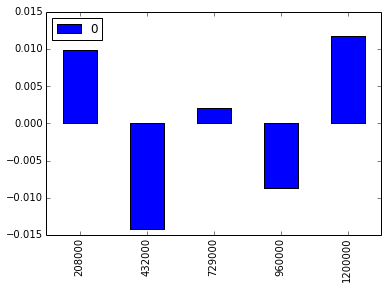

In [16]:
index = sorted(mean_diffs.keys())
pd.DataFrame([mean_diffs[f] for f in index], index=index).plot(kind='bar')